# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets includ

In [47]:
X = boston["data"]
y = boston["target"]

In [48]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [49]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.26333786052302

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [60]:
from sklearn.linear_model import LinearRegression

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    data = {}
    data['first_degree'] = np.zeros(X.shape[0])
    data['second_degree'] = np.zeros(X.shape[0])
    data['used'] = np.zeros(X.shape[0])
    data['error'] = np.zeros(X.shape[0])
    for run in range(num_runs):
        idxs = np.random.default_rng().integers(0, X.shape[0], X.shape[0])
        X_j = X[idxs]
        out_of_bag = np.setdiff1d(np.arange(X.shape[0]), idxs)
        T_j = X[out_of_bag]
#         print(idxs)
#         print(X_j)
#         print(T_j)
        regressor.fit(X_j, y[idxs])
        pred = regressor.predict(T_j)
        real = y[out_of_bag]
        
        data['used'][out_of_bag] += 1
        data['first_degree'][out_of_bag] += pred
        data['second_degree'][out_of_bag] += pred ** 2
        data['error'][out_of_bag] += (pred - real) ** 2
#     print(data['first_degree'])
#     print(data['second_degree'])
#     print(data['used'])
    used = np.where(data['used'] > 0)
    expected_value = data['first_degree'][used] / data['used'][used]
    expected_value_squared = data['second_degree'][used] / data['used'][used]
    
    '''
    Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. 
    Среднее предсказание берется только по тем алгоритмам  𝑎𝑗 , для которых этот объект входил в out-of-bag выборку  𝑇𝑗 . 
    Для получения общего смещения выполнить усреденение смещений по объектам.'''
    bias = np.mean((expected_value - y[used]) ** 2)
    
    '''
    Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов  𝑎𝑗 , 
    для которых этот объект входил в out-of-bag выборку  𝑇𝑗 .
    Для получения общего разброса выполнить усреденение разбросов по объектам.
    '''
    variance = np.mean(expected_value_squared - expected_value ** 2)
    
    '''
    Ошибка  𝐿 : усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.
    '''
    L = np.mean(data['error'][used] / data['used'][used])
    
    assert np.isclose(L, bias + variance)
    
    return bias, variance, L
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [67]:
from sklearn.linear_model import LinearRegression
bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
print(f'results for linear regression: \nbias = {bias},\nvariance = {variance},\nerror = {error}\n')

from sklearn.tree import DecisionTreeRegressor
bias, variance, error = compute_biase_variance(DecisionTreeRegressor(), X, y)
print(f'results for decision tree: \nbias = {bias},\nvariance = {variance},\nerror = {error}\n')

from sklearn.ensemble import RandomForestRegressor
bias, variance, error = compute_biase_variance(RandomForestRegressor(), X, y)
print(f'results for random forest: \nbias = {bias},\nvariance = {variance},\nerror = {error}')

results for linear regression: 
bias = 23.700309939344717,
variance = 0.9212032790414666,
error = 24.62151321838619

results for decision tree: 
bias = 10.381603434215217,
variance = 13.094395596738824,
error = 23.475999030953975

results for random forest: 
bias = 10.570120396442816,
variance = 2.2279706605550342,
error = 12.798091056997864


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ На занятиях обсуждали следующее:

1) у линейных моделей маленькое смещение, если зависимость действительно линейная, и большое смещение в ином случае, при этом разброс небольшой

2) у деревьев маленькое смещение (модель легко подстраивается под данные) и большой разброс (при малом изменении в выборке можно получить абсолютно другое дерево), но если установить ограничения на модель (глубина, количество объектов в листе), будет расти смещение и уменьшаться разброс

3) случайный лес – это бэггинг над решающими деревьями, смещение композиции, полученной с помощью бэггинга, совпадает со смещением одного базового алгоритма, а разброс может уменьшиться в лучшем случае в N раз (если модели нескоррелированные)


По итогам экспериментов получилось, что у линейной регрессии действительно маленький разброс (а смещение большое, потому что зависимость таргета нелинейная); смещение у решающего дерева меньше, чем у регресии, но такое же, как у случайного леса, при этом разброс рещающего дерева сильно больше, чем разброс случайного леса

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ Для линейной регрессии и случайного леса разброс не поменялся (потому что, видимо, построенные модели были сильно скоррелированы), для решающего дерева – поменялся (потому что, видимо, все модели были несвязанными и нескоррелированными; помним, что построенное дерево очень сильно подстраивается под выборку, а в бутстраппированные выборки могло попасть всё что угодно)

In [69]:
from sklearn.ensemble import BaggingRegressor
bias, variance, error = compute_biase_variance(BaggingRegressor(LinearRegression(), n_jobs=-1), X, y)
print(f'results for linear regression: \nbias = {bias},\nvariance = {variance},\nerror = {error}\n')

bias, variance, error = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor(), n_jobs=-1), X, y)
print(f'results for decision tree: \nbias = {bias},\nvariance = {variance},\nerror = {error}\n')

bias, variance, error = compute_biase_variance(BaggingRegressor(RandomForestRegressor(), n_jobs=-1), X, y)
print(f'results for random forest: \nbias = {bias},\nvariance = {variance},\nerror = {error}')

results for linear regression: 
bias = 23.763355898573515,
variance = 1.0374071896520596,
error = 24.80076308822552

results for decision tree: 
bias = 10.610021988486144,
variance = 3.3973880765299604,
error = 14.007410065016092

results for random forest: 
bias = 11.746387123099296,
variance = 1.4172885653579068,
error = 13.163675688457221


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [135]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", axs=None):
    """
    plot graphics described above
    """
    test_idxs = np.random.default_rng().integers(0, X.shape[0], num_test_objects)
    train_idxs = np.setdiff1d(np.arange(X.shape[0]), test_idxs)
    X_train, y_train = X[train_idxs], y[train_idxs]
    X_test, y_test = X[test_idxs], y[test_idxs]
    axs.set_ylabel("Prediction")
    axs.set_xlabel("Test objects")
    axs.set_title(title)
    for run in range(num_runs):
        boot_idxs = np.random.default_rng().choice(train_idxs, train_idxs.shape[0], replace=True)
        X_boot, y_boot = X[boot_idxs], y[boot_idxs]
        regressor.fit(X=X_boot, y=y_boot)
        pred = regressor.predict(X_test)
        axs.scatter(np.arange(num_test_objects), pred, c='cyan')
    axs.scatter(np.arange(num_test_objects), y_test, c='black')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

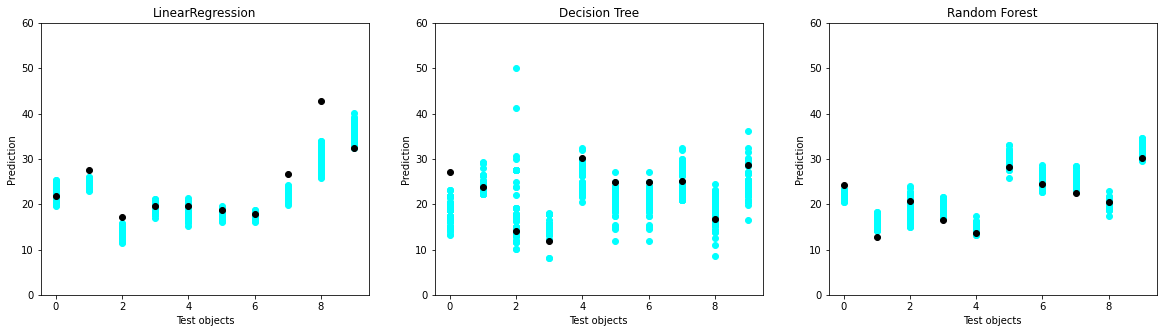

In [141]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
axs[0].set_ylim(0, 60)
axs[1].set_ylim(0, 60)
axs[2].set_ylim(0, 60)
plot_predictions(LinearRegression(), X, y, title="LinearRegression", axs=axs[0])
plot_predictions(DecisionTreeRegressor(), X, y, title="Decision Tree", axs=axs[1])
plot_predictions(RandomForestRegressor(), X, y, title="Random Forest", axs=axs[2])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ У линейной регрессии большое смещение – чёрные точки и бирюзовые скопления точек часто не пересекаются, при этом разброс сравнительно небольшой. У рашающего дерева маленькое смещение – чёрные точки попадают на бирюзовые скопления точек, и большой разброс – бирюзовые скопления точек, т.е. предсказания, растянуты по вертикали. У случайного леса тоже небольшое смещение, а разброс меньше, чем у дерева, но больше, чем у регрессии.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

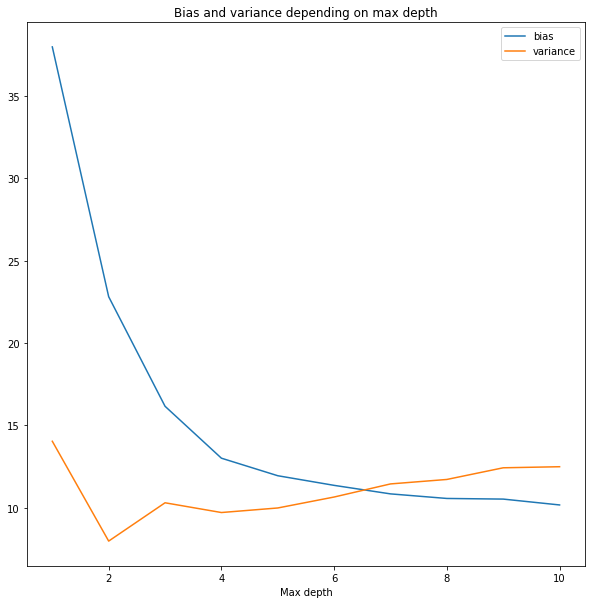

In [143]:
depths = range(1, 11)

b, v = [], []
for depth in depths:
    bias, var, error = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    b.append(bias)
    v.append(var)
fig, axs = plt.subplots(figsize=(10, 10))
axs.plot(depths, b, label='bias')
axs.plot(depths, v, label='variance')
axs.set_title('Bias and variance depending on max depth')
axs.set_xlabel('Max depth')
axs.legend()
plt.show()

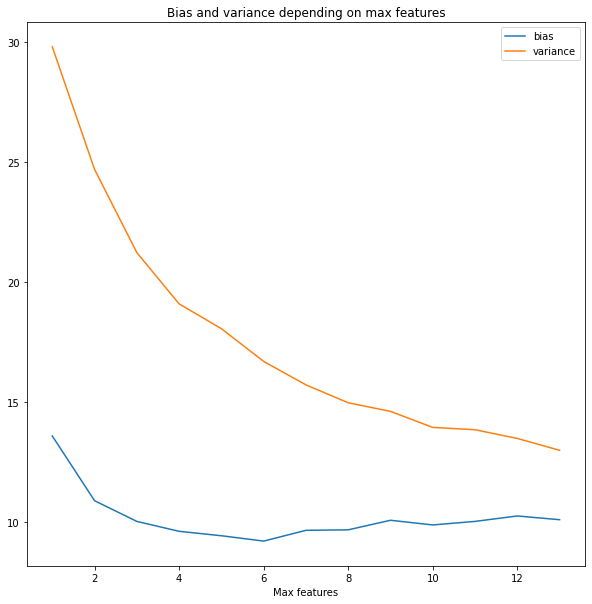

In [146]:
b, v = [], []
max_features = range(1, X.shape[1] + 1)
for num_feature in max_features:
    bias, var, error = compute_biase_variance(DecisionTreeRegressor(max_features=num_feature), X, y)
    b.append(bias)
    v.append(var)
fig, axs = plt.subplots(figsize=(10, 10))
axs.plot(max_features, b, label='bias')
axs.plot(max_features, v, label='variance')
axs.set_title('Bias and variance depending on max features')
axs.set_xlabel('Max features')
axs.legend()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

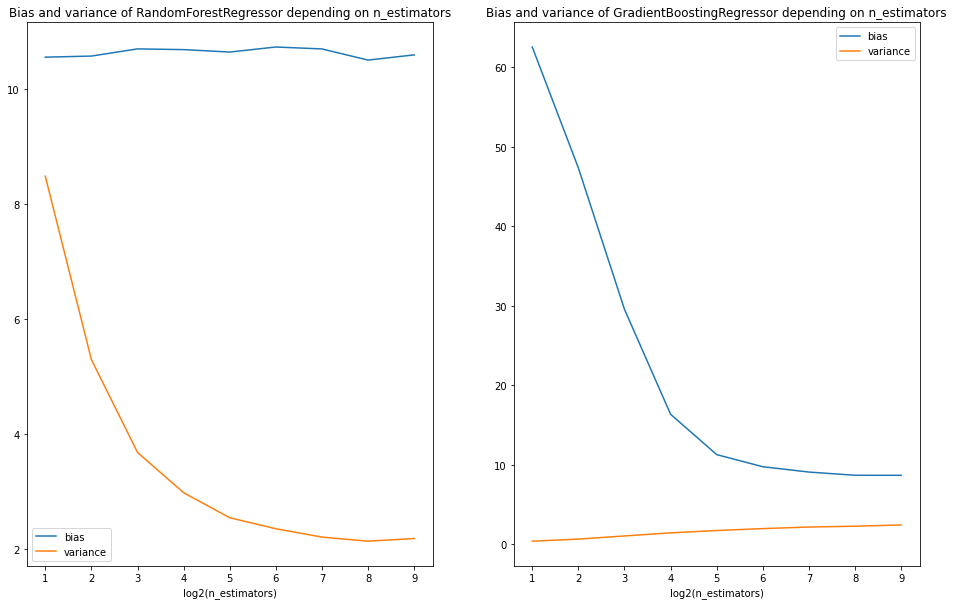

In [159]:
from sklearn.ensemble import GradientBoostingRegressor


b_forest, v_forest = [], []
b_boosting, v_boosting = [], []
for i in np.arange(1, 10):
    b_f, v_f, e_f = compute_biase_variance(RandomForestRegressor(n_estimators = 2 ** i, n_jobs=-1), X, y)
    b_forest.append(b_f)
    v_forest.append(v_f)
    
    b_b, v_b, e_b = compute_biase_variance(GradientBoostingRegressor(n_estimators = 2 ** i), X, y)
    b_boosting.append(b_b)
    v_boosting.append(v_b)
    
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs[0].plot(np.arange(1, 10), b_forest, label='bias')
axs[0].plot(np.arange(1, 10), v_forest, label='variance')
axs[0].set_title('Bias and variance of RandomForestRegressor depending on n_estimators')
axs[0].set_xlabel('log2(n_estimators)')
axs[0].legend()

axs[1].plot(np.arange(1, 10), b_boosting, label='bias')
axs[1].plot(np.arange(1, 10), v_boosting, label='variance')
axs[1].set_title('Bias and variance of GradientBoostingRegressor depending on n_estimators')
axs[1].set_xlabel('log2(n_estimators)')
axs[1].legend()


plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
1) График зависимости bias и variance у DecisionTree от параметра max_depth. Видим, что чем больше max depth, тем меньше bias, при этом на variance этот параметр не влияет почти никак. Логично, что bias падает – ведь чем глубже дерево, тем больше трешхолдов можно перебрать и тем точнее можно подстроиться под выборку. Variance никак не меняется, потому что дерево будет сильно подстраиваться под выборку в любом случае и модели, обученные на бустрапированных выборках, могут получиться совсем разными

2) График зависимости bias и variance у DecisionTree от параметра max_features. Тут всё наоборот: bias стабильный, а variance падает с увеличением max features. Max features – это количество признаков, на которые смотрит модель во время обучения (The number of features to consider when looking for the best split). Если все модели будут смотреть на ~все признаки во время обучения, они будут похожими (потому что будут находиться примерно одинаковые трешхолды каждый раз), и предсказания этих моделей будут похожими, поэтому variance и падает. При этом bias падает лишь совсем чуть-чуть, поскольку дерево и так является сложной моделью (по сравнению, к примеру, с линейной регрессией), и добавление признаков на каждом сплите не сильно её усложняет

3) График зависимости bias и variance у случайного леса в зависимости от n_estimators: bias почти не меняется, variance сильно падает. N_estimators в случайном лесе – это количество деревьев, входящих в лес. Random Forest – это бэггинг над деревьями, bias у бэггинга такой же, какой был у исходной модели (то есть у леса такой же, как у дерева), при этом variance падает, если модели некоррелированы. Деревья сильно подстраиваются под выборку => разные и некоррелированные => variance падает

4) График зависимости bias и variance у градиентного бустинга в зависимости от n_estimators: bias сильно падает, variance почти не меняется (и даже немного растёт). В градиентном бустинге каждая новая модель пытается исправить ошибки предыдущих, чем больше используем базовых моделей, тем сложнее получается итоговая модель, и благодаря этому смещение снижается. При этом модель может оказаться не просто сложной, но переобученной, то есть её предсказания могут быть как оптимальными, так и рандомными, поэтому при бустинге разброс либо остаётся неизменным, либо растёт

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__ 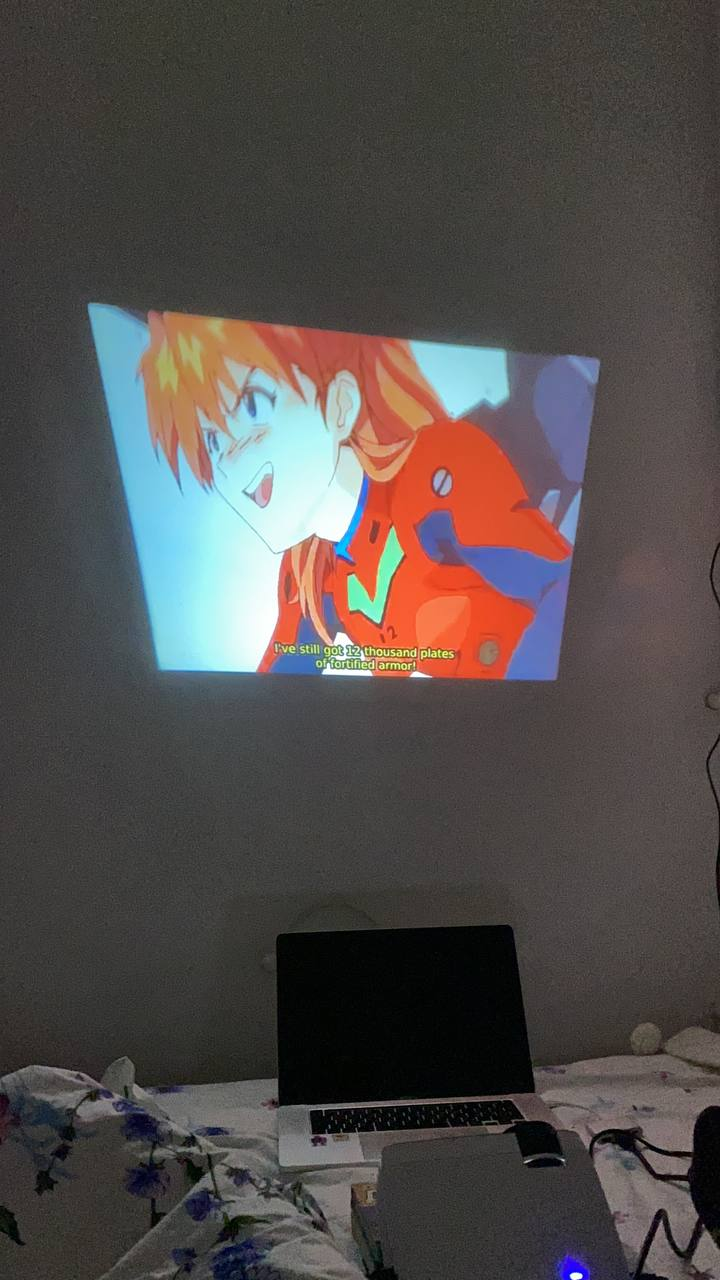